### Two-point correlation functions for shear and convergence in DC2

In this notebook, we compute two-point correlation functions for shear and convergence using a catalog of DC2 galaxies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

import treecorr
import pyccl

import torch

### Load data

In [2]:
# This cell takes about 30 seconds
catalog = pd.read_pickle('/data/scratch/dc2local/dc2_lensing_catalog.pkl')

### Empirical two-point correlations using `treecorr`

In [3]:
cat = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                       g1 = catalog["shear_1"], g2 = catalog["shear_2"], k = catalog["convergence"])

#### Shear

In [4]:
# This cell takes less than a minute
gg = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg.process(cat)

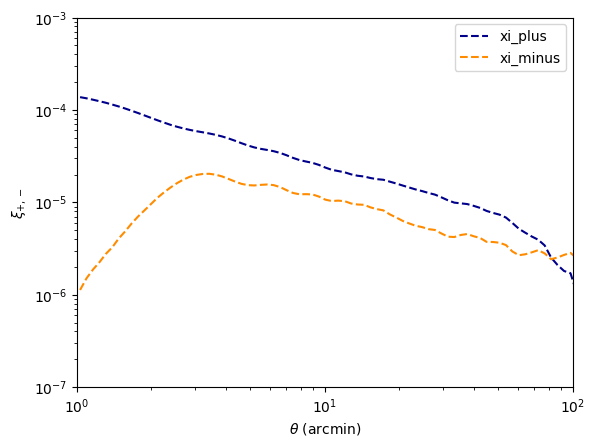

In [5]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = '--', label = 'xi_minus')
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

#### Convergence

In [6]:
# This cell takes less than a minute
kk = treecorr.KKCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
kk.process(cat)

We confirm that the two-point correlation function of the convergence is identical to $\xi_+$ for shear as the number of galaxies in the sample $\rightarrow \infty$ (see, e.g., Kilbinger 2015 sec 3.8). The discrepancy for larger $\theta$ in the plot below is due to the fact that we are using a finite sample.

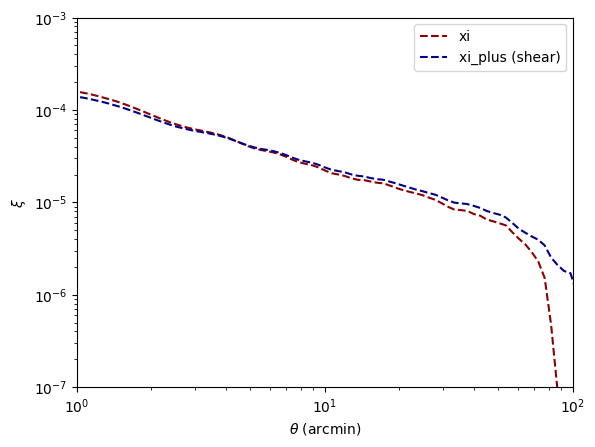

In [7]:
r = np.exp(kk.meanlogr)
xi = kk.xi

_ = plt.plot(r, xi, color = 'darkred', linestyle = '--', label = 'xi')
_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = 'xi_plus (shear)')
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

### Theoretical two-point correlations using `pyccl`

The assumed cosmology for CosmoDC2 is close to the best fitting parameters from WMAP-7 (see TXPipe paper).

In [8]:
wmap7_cosmo = pyccl.cosmology.Cosmology(Omega_c = 0.22,
                                        Omega_b = 0.048,
                                        h = 0.71,
                                        n_s = 0.963,
                                        sigma8 = 0.8)

The redshift distribution of our collection of galaxies is as follows:

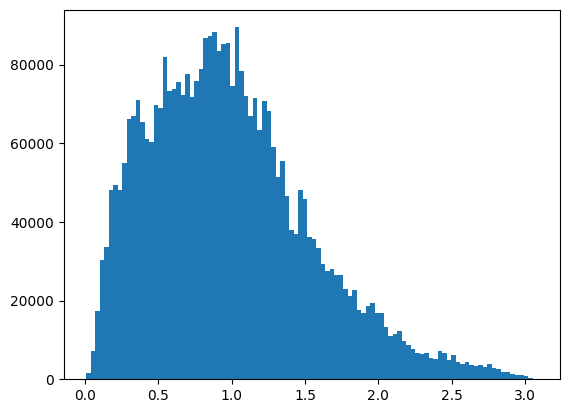

In [9]:
_ = plt.hist(catalog['redshift'], bins = 100)

We model this as a normal distribution with mean 0.9 and standard deviation 0.55 on the interval [0,3]:

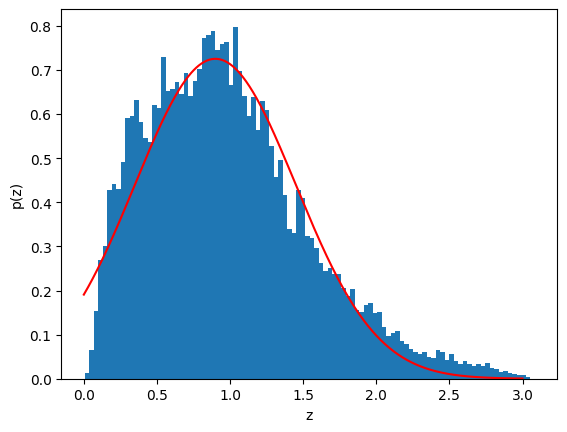

In [10]:
z = np.linspace(0.001, 3, 512)
n = norm.pdf(z, 0.9, 0.55)

_ = plt.hist(catalog['redshift'], bins = 100, density = True)
_ = plt.plot(z, n, color = 'red')
_ = plt.xlabel('z')
_ = plt.ylabel('p(z)')

We create a weak lensing tracer using the above cosmology and redshift distribution, and then we compute the angular power spectrum, which is the harmonic-space equivalent of the two-point correlation function.

In [11]:
lensing_tracer = pyccl.WeakLensingTracer(wmap7_cosmo, dndz=(z, n))

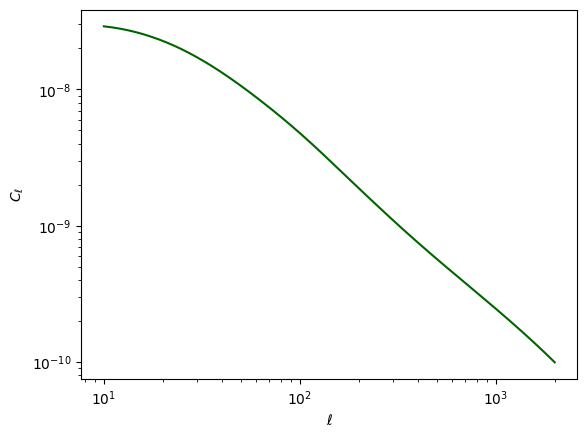

In [12]:
ell = np.arange(10, 2000)
cl = pyccl.angular_cl(wmap7_cosmo, lensing_tracer, lensing_tracer, ell)

_ = plt.plot(ell, cl, color = 'darkgreen')
_ = plt.xlabel('$\ell$')
_ = plt.ylabel('$C_\ell$')
_ = plt.xscale('log')
_ = plt.yscale('log')

And finally, we use the angular power spectrum to compute the two-point correlation function $\xi_{+,-}$.

In [13]:
theta_degrees = r/60  # 1 degree is 60 arcmins

xip_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG+')
xim_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG-')

We find that the theoretical correlation function is pretty close to the empirical DC2 correlation function.

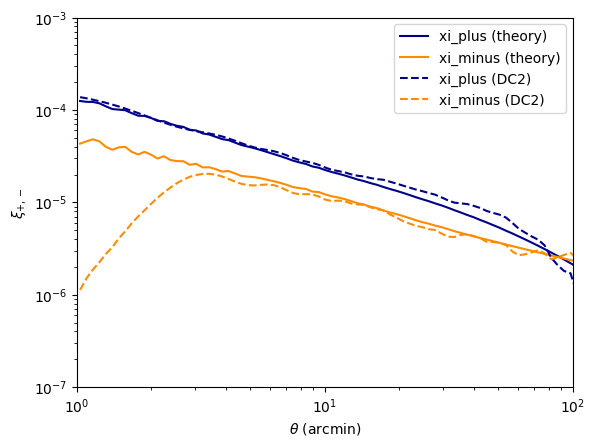

In [14]:
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2)")
_ = plt.plot(r, xim, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

### Empirical two-point correlations using a smaller region

In [15]:
# thresholds defined by test set
radec_mask = (catalog['ra'] > 57.5081) & (catalog['ra'] < 58.0660) & (catalog['dec'] > -37.2150) & (catalog['dec'] < -35.6714)

In [16]:
cat_subset = treecorr.Catalog(ra = catalog["ra"][radec_mask], dec = catalog["dec"][radec_mask], ra_units = "deg", dec_units = "deg",
                              g1 = catalog["shear_1"][radec_mask], g2 = catalog["shear_2"][radec_mask], k = catalog["convergence"][radec_mask])

In [17]:
gg_subset = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_subset.process(cat_subset)

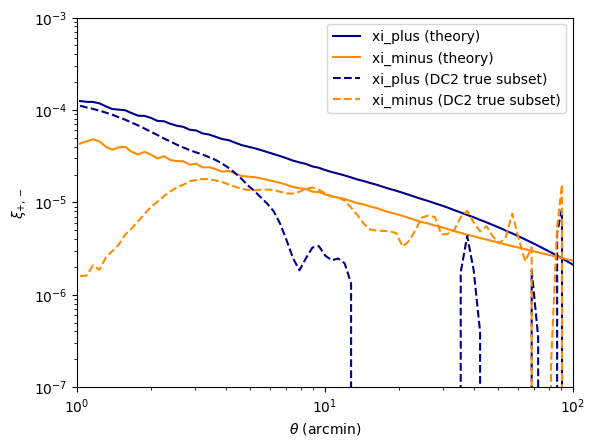

In [18]:
r = np.exp(gg_subset.meanlogr)
xip_subset = gg_subset.xip
xim_subset = gg_subset.xim

_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip_subset, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2 true subset)")
_ = plt.plot(r, xim_subset, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2 true subset)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

---

### Empirical two-point correlations using ellipticities instead of shear

In [19]:
shear1 = torch.from_numpy(catalog["shear_1"].values)
shear2 = torch.from_numpy(catalog["shear_2"].values)
complex_shear = shear1 + shear2 * 1j
convergence = torch.from_numpy(catalog["convergence"].values)
reduced_shear = complex_shear / (1.0 - convergence)

We first use the true ellipticities:

In [20]:
ellip1_intrinsic = torch.from_numpy(catalog["ellipticity_1_true_dc2"].values)
ellip2_intrinsic = torch.from_numpy(catalog["ellipticity_2_true_dc2"].values)
complex_ellip_intrinsic = ellip1_intrinsic + ellip2_intrinsic * 1j
complex_ellip_lensed = (complex_ellip_intrinsic + reduced_shear) / (
    1.0 + reduced_shear.conj() * complex_ellip_intrinsic
)
ellip1_lensed = torch.view_as_real(complex_ellip_lensed)[..., 0].numpy()
ellip2_lensed = torch.view_as_real(complex_ellip_lensed)[..., 1].numpy()

In [21]:
cat_ellip_true = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                                  g1 = ellip1_lensed, g2 = ellip2_lensed)

In [22]:
gg_ellip_true = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_ellip_true.process(cat_ellip_true)

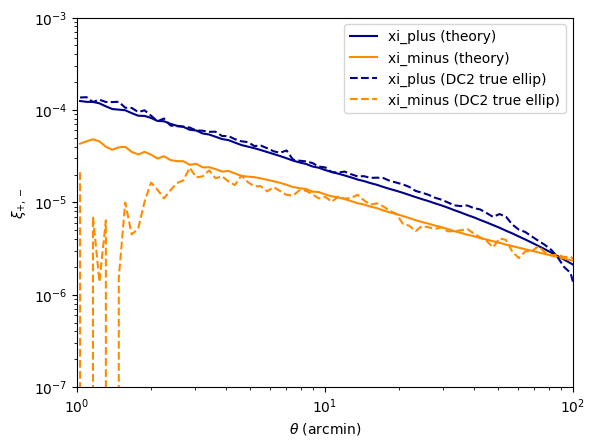

In [23]:
r = np.exp(gg_ellip_true.meanlogr)
xip_ellip_true = gg_ellip_true.xip
xim_ellip_true = gg_ellip_true.xim

_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip_ellip_true, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2 true ellip)")
_ = plt.plot(r, xim_ellip_true, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2 true ellip)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

We can also estimate the 2PCF using the smaller region defined by `radec_mask`:

In [24]:
cat_ellip_true_subset = treecorr.Catalog(ra = catalog["ra"][radec_mask], dec = catalog["dec"][radec_mask], ra_units = "deg", dec_units = "deg",
                                         g1 = ellip1_lensed[radec_mask], g2 = ellip2_lensed[radec_mask])

In [25]:
gg_ellip_true_subset = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_ellip_true_subset.process(cat_ellip_true_subset)

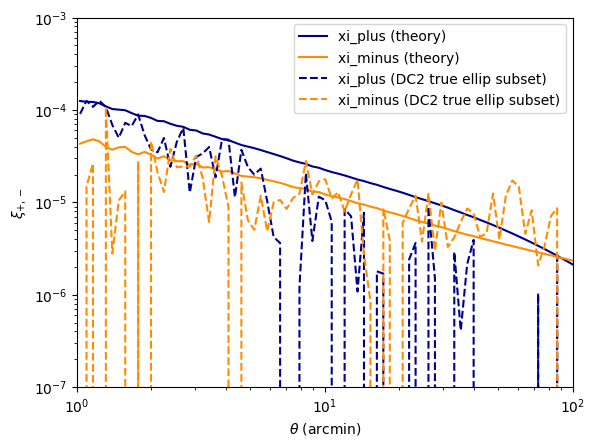

In [26]:
r = np.exp(gg_ellip_true_subset.meanlogr)
xip_ellip_true_subset = gg_ellip_true_subset.xip
xim_ellip_true_subset = gg_ellip_true_subset.xim

_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip_ellip_true_subset, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2 true ellip subset)")
_ = plt.plot(r, xim_ellip_true_subset, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2 true ellip subset)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

Now we use the LSST-estimated ellipticities:

In [27]:
ixx = torch.from_numpy(catalog["Iyy_pixel"].values)
iyy = torch.from_numpy(catalog["Ixx_pixel"].values)
ixy = torch.from_numpy(catalog["Ixy_pixel"].values)
ellip_lsst = (ixx - iyy + 2j * ixy) / (ixx + iyy + 2 * np.sqrt(ixx * iyy - (ixy**2)))
ellip1_lsst = torch.view_as_real(ellip_lsst)[..., 0].numpy()
ellip2_lsst = torch.view_as_real(ellip_lsst)[..., 1].numpy()

In [28]:
cat_ellip_lsst = treecorr.Catalog(ra = catalog["ra"][~np.isnan(ellip1_lsst)], dec = catalog["dec"][~np.isnan(ellip1_lsst)], ra_units = "deg", dec_units = "deg",
                                  g1 = ellip1_lsst[~np.isnan(ellip1_lsst)], g2 = ellip2_lsst[~np.isnan(ellip1_lsst)])

In [29]:
gg_ellip_lsst = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_ellip_lsst.process(cat_ellip_lsst)

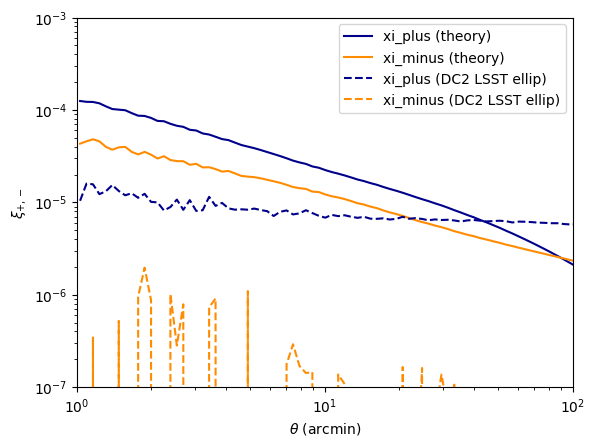

In [30]:
r = np.exp(gg_ellip_lsst.meanlogr)
xip_ellip_lsst = gg_ellip_lsst.xip
xim_ellip_lsst = gg_ellip_lsst.xim

_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.plot(r, xip_ellip_lsst, color = 'darkblue', linestyle = '--', label = "xi_plus (DC2 LSST ellip)")
_ = plt.plot(r, xim_ellip_lsst, color = 'darkorange', linestyle = '--', label = "xi_minus (DC2 LSST ellip)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

---

### Empirical two-point correlations with noisy estimates of shear and convergence

##### Gaussian noise

Standard deviation of 0.01 (typical for shear):

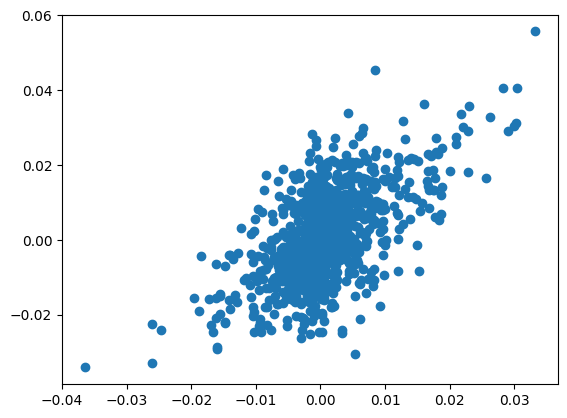

In [31]:
shear1 = catalog["shear_1"] + np.random.normal(size = catalog["shear_1"].shape[0], scale = 0.01)
shear2 = catalog["shear_2"] + np.random.normal(size = catalog["shear_2"].shape[0], scale = 0.01)
convergence = catalog["convergence"] + np.random.normal(size = catalog["convergence"].shape[0], scale = 0.01)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [32]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

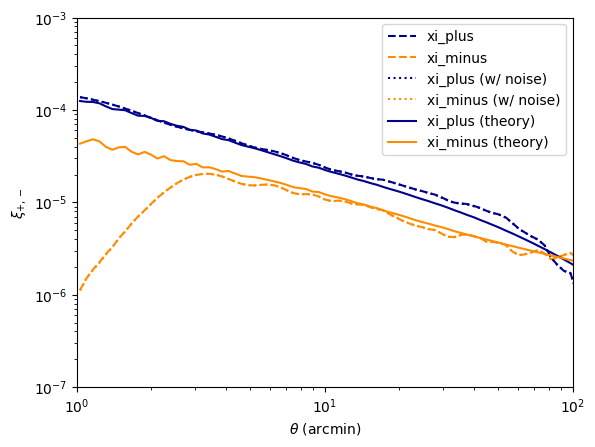

In [33]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

Standard deviation of 0.1 (high):

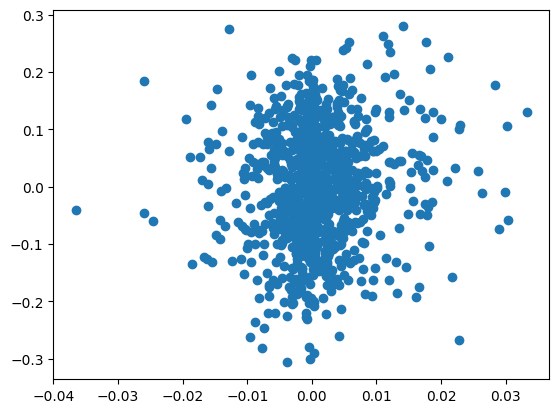

In [34]:
shear1 = catalog["shear_1"] + np.random.normal(size = catalog["shear_1"].shape[0], scale = 0.1)
shear2 = catalog["shear_2"] + np.random.normal(size = catalog["shear_2"].shape[0], scale = 0.1)
convergence = catalog["convergence"] + np.random.normal(size = catalog["convergence"].shape[0], scale = 0.1)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [35]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

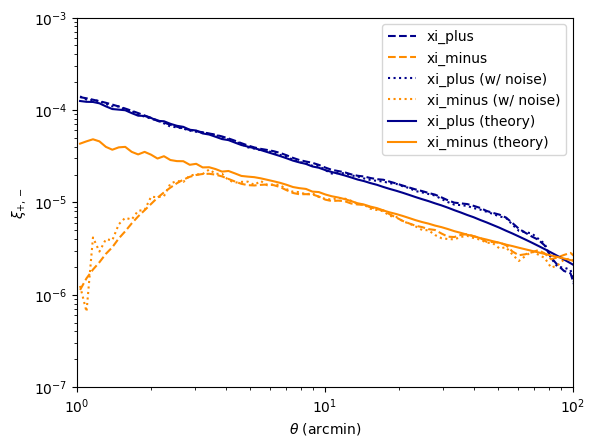

In [36]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

Standard deviation of 0.5 (unrealistically high):

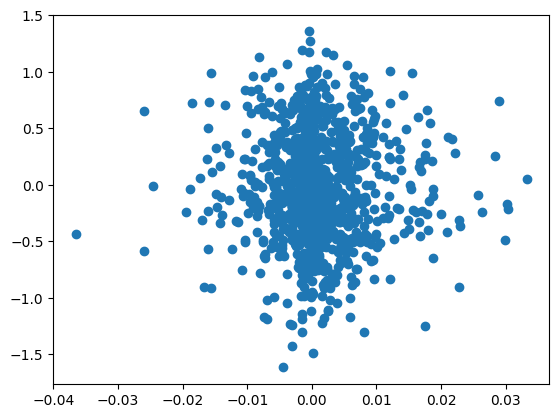

In [37]:
shear1 = catalog["shear_1"] + np.random.normal(size = catalog["shear_1"].shape[0], scale = 0.5)
shear2 = catalog["shear_2"] + np.random.normal(size = catalog["shear_2"].shape[0], scale = 0.5)
convergence = catalog["convergence"] + np.random.normal(size = catalog["convergence"].shape[0], scale = 0.5)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [38]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

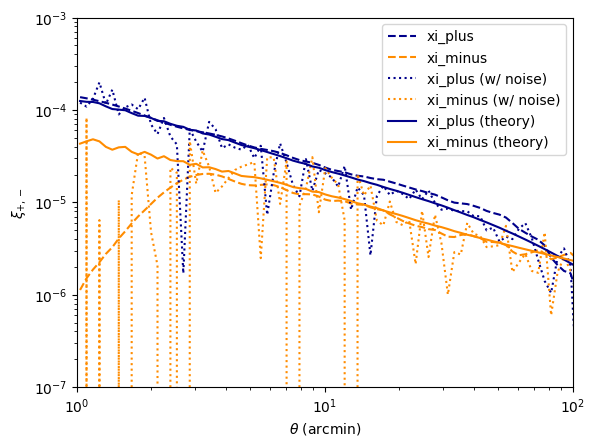

In [39]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

##### Uniform noise

Uniform noise on [-0.01, 0.01]:

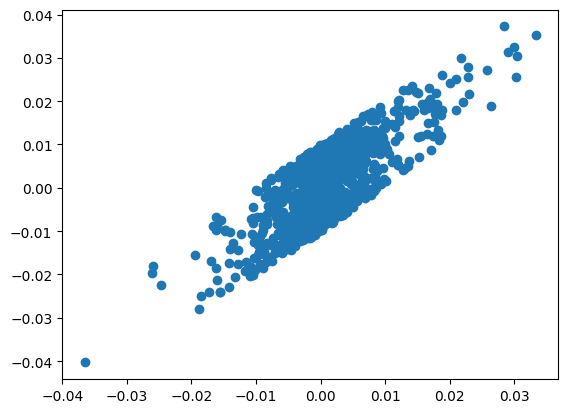

In [40]:
shear1 = catalog["shear_1"] + np.random.uniform(size = catalog["shear_1"].shape[0], low = -0.01, high = 0.01)
shear2 = catalog["shear_2"] + np.random.uniform(size = catalog["shear_2"].shape[0], low = -0.01, high = 0.01)
convergence = catalog["convergence"] + np.random.uniform(size = catalog["convergence"].shape[0], low = -0.01, high = 0.01)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [41]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

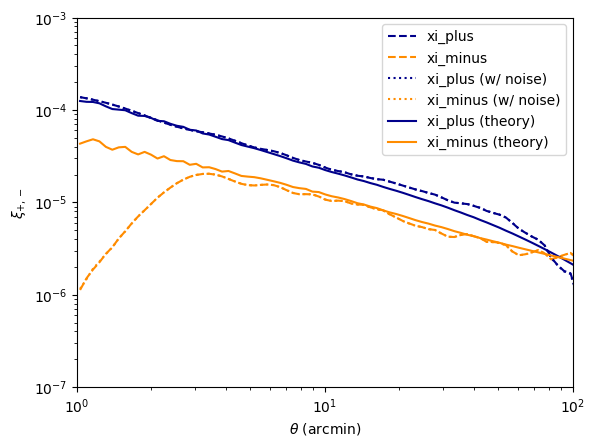

In [42]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

Uniform noise on [-0.1, 0.1]:

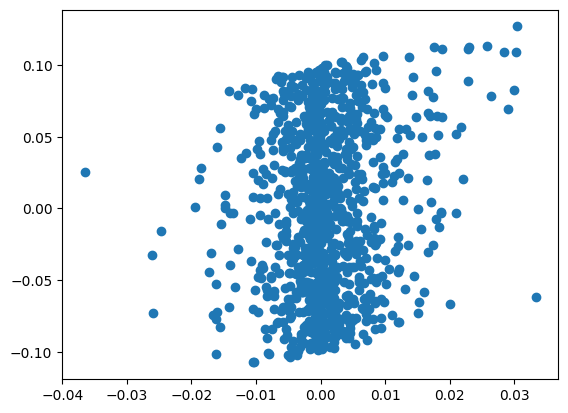

In [43]:
shear1 = catalog["shear_1"] + np.random.uniform(size = catalog["shear_1"].shape[0], low = -0.1, high = 0.1)
shear2 = catalog["shear_2"] + np.random.uniform(size = catalog["shear_2"].shape[0], low = -0.1, high = 0.1)
convergence = catalog["convergence"] + np.random.uniform(size = catalog["convergence"].shape[0], low = -0.1, high = 0.1)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [44]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

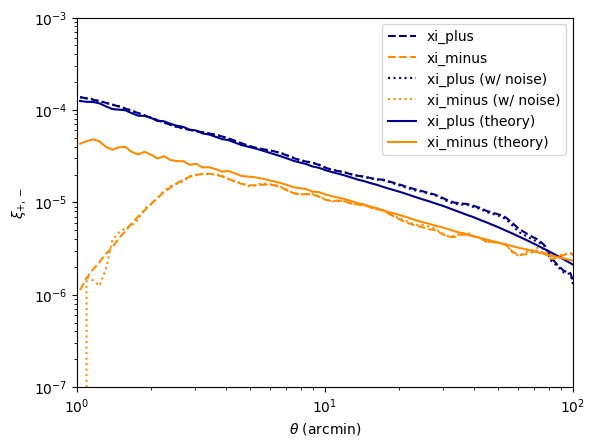

In [45]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

##### Cauchy noise

In [46]:
from scipy.stats import cauchy

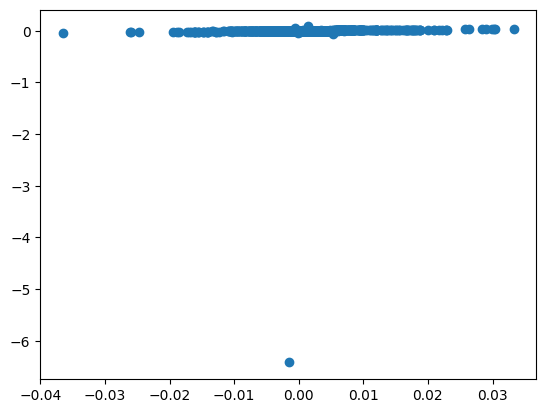

In [47]:
shear1 = catalog["shear_1"] + cauchy.rvs(size = catalog["shear_1"].shape[0], scale = 0.0001)
shear2 = catalog["shear_2"] + cauchy.rvs(size = catalog["shear_2"].shape[0], scale = 0.0001)
convergence = catalog["convergence"] + cauchy.rvs(size = catalog["convergence"].shape[0], scale = 0.0001)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [48]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

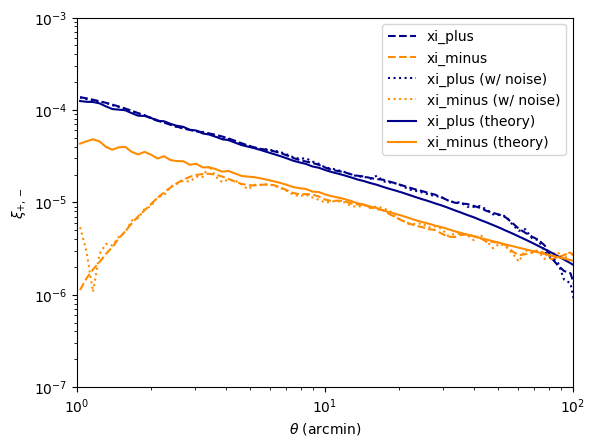

In [49]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

##### Gamma noise

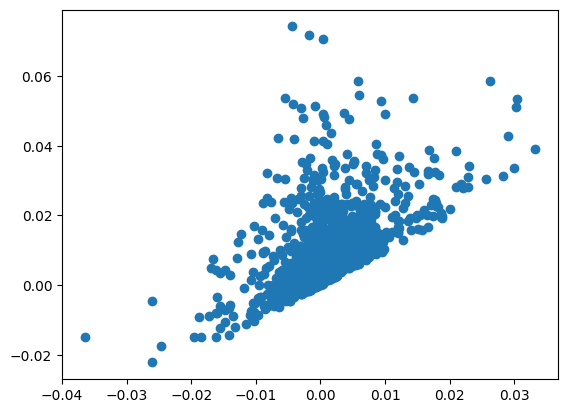

In [50]:
shear1 = catalog["shear_1"] + np.random.gamma(size = catalog["shear_1"].shape[0], shape = 1, scale = 0.01)
shear2 = catalog["shear_2"] + np.random.gamma(size = catalog["shear_2"].shape[0], shape = 1, scale = 0.01)
convergence = catalog["convergence"] + np.random.gamma(size = catalog["convergence"].shape[0], shape = 1, scale = 0.01)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])

In [51]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

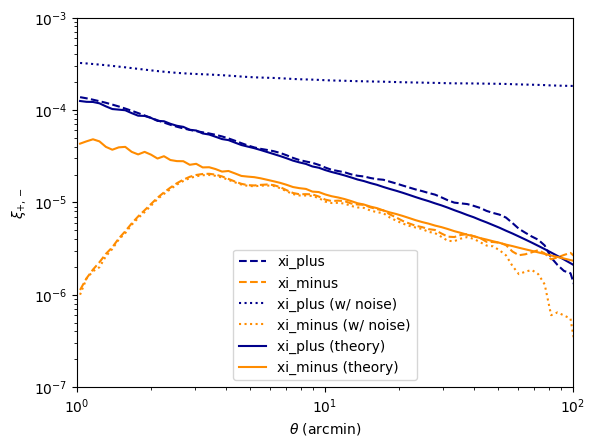

In [52]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

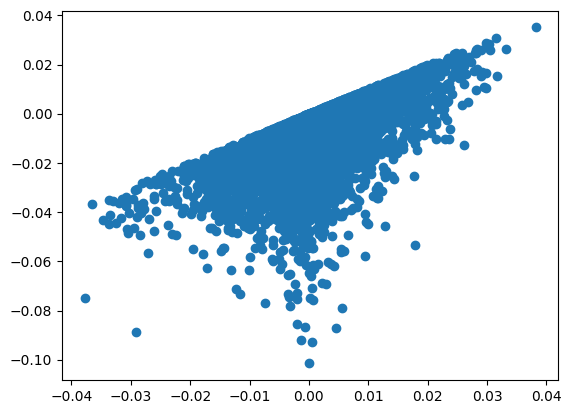

In [53]:
shear1 = catalog["shear_1"] - np.random.gamma(size = catalog["shear_1"].shape[0], shape = 1, scale = 0.01)
shear2 = catalog["shear_2"] - np.random.gamma(size = catalog["shear_2"].shape[0], shape = 1, scale = 0.01)
convergence = catalog["convergence"] - np.random.gamma(size = catalog["convergence"].shape[0], shape = 1, scale = 0.01)

_ = plt.scatter(catalog["shear_1"][:10000], shear1[:10000])

In [54]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

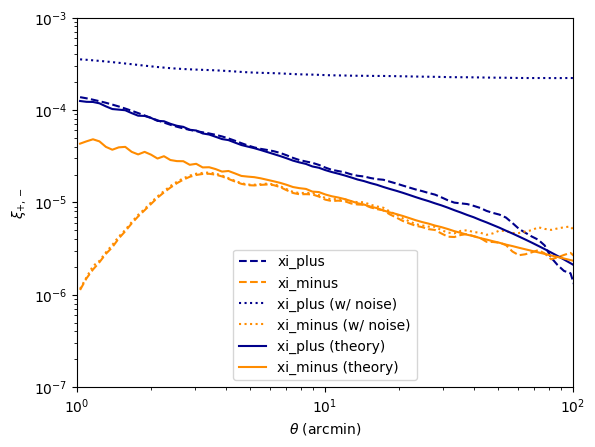

In [55]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])

### Bias with Gaussian noise

In [56]:
m = 0.1

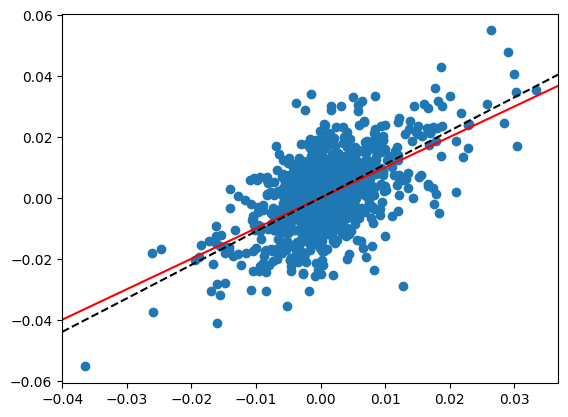

In [57]:
shear1 = (1 + m) * catalog["shear_1"] + np.random.normal(size = catalog["shear_1"].shape[0], scale = 0.01)
shear2 = (1 + m) * catalog["shear_2"] + np.random.normal(size = catalog["shear_2"].shape[0], scale = 0.01)
convergence = (1 + m) * catalog["convergence"] + np.random.normal(size = catalog["convergence"].shape[0], scale = 0.01)

_ = plt.scatter(catalog["shear_1"][:1000], shear1[:1000])
_ = plt.axline((0,0), slope = 1, color = 'red', linestyle = 'solid')
_ = plt.axline((0,0), slope = 1 + m, color = 'black', linestyle = 'dashed')

In [58]:
cat_noisy = treecorr.Catalog(ra = catalog["ra"], dec = catalog["dec"], ra_units = "deg", dec_units = "deg",
                             g1 = shear1, g2 = shear2, k = convergence)
gg_noisy = treecorr.GGCorrelation(min_sep = 1, max_sep = 400, nbins = 100, sep_units = 'arcmin')
gg_noisy.process(cat_noisy)

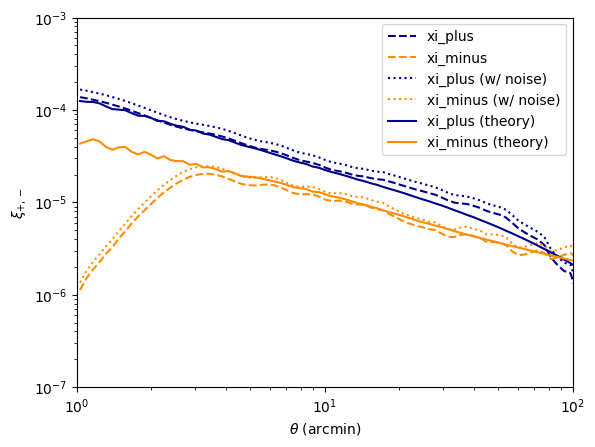

In [59]:
r = np.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
xip_noisy = gg_noisy.xip
xim_noisy = gg_noisy.xim

_ = plt.plot(r, xip, color = 'darkblue', linestyle = 'dashed', label = 'xi_plus')
_ = plt.plot(r, xim, color = 'darkorange', linestyle = 'dashed', label = 'xi_minus')
_ = plt.plot(r, xip_noisy, color = 'darkblue', linestyle = 'dotted', label = 'xi_plus (w/ noise)')
_ = plt.plot(r, xim_noisy, color = 'darkorange', linestyle = 'dotted', label = 'xi_minus (w/ noise)')
_ = plt.plot(60 * theta_degrees, xip_theory, color = 'darkblue', label = "xi_plus (theory)")
_ = plt.plot(60 * theta_degrees, xim_theory, color = 'darkorange', label = "xi_minus (theory)")
_ = plt.legend()

_ = plt.xscale('log')
_ = plt.yscale('log')

_ = plt.xlabel(r'$\theta$ (arcmin)')
_ = plt.ylabel(r'$\xi_{+,-}$')

_ = plt.xlim([1,100])
_ = plt.ylim([1e-7,1e-3])